This Notebook contains dividing solubility dataset into clusters, training support vector regressor and random forest regressor on each cluster separately. 

# Import Libraries

In [1]:
import pandas as pd
#pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import pickle
import os
import shutil
from sklearn.svm import SVR
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Import Data

In [2]:
pd.set_option('display.max_columns', None)
df1 = pd.read_csv('data/final_rcpi_dataset_noZV.txt', delimiter = "\t")
# remove unwanted column
data = df1.drop('smiles.solute',axis=1)
data.head()

,logS_aq_avg,ALogP,ALogp2,AMR,naAromAtom,nAromBond,nAtom,ATSm1,ATSm2,ATSm3,ATSm4,ATSm5,ATSp1,ATSp2,ATSp3,ATSp4,ATSp5,nB,C1SP1,C2SP1,C1SP2,C2SP2,C3SP2,C1SP3,C2SP3,C3SP3,C4SP3,ECCEN,FMF,fragC,nHBAcc,nHBDon,HybRatio,Kier1,Kier2,Kier3,khs.sssB,khs.sCH3,khs.dCH2,khs.ssCH2,khs.tCH,khs.dsCH,khs.aaCH,khs.sssCH,khs.ddC,khs.tsC,khs.dssC,khs.aasC,khs.aaaC,khs.ssssC,khs.sNH2,khs.dNH,khs.ssNH,khs.aaNH,khs.tN,khs.dsN,khs.aaN,khs.sssN,khs.ddsN,khs.aasN,khs.sOH,khs.dO,khs.ssO,khs.aaO,khs.sF,khs.sssP,khs.dsssP,khs.sSH,khs.dS,khs.ssS,khs.aaS,khs.dssS,khs.ddssS,khs.sCl,khs.sBr,khs.sI,nAtomLC,nAtomP,nAtomLAC,MDEC.11,MDEC.12,MDEC.13,MDEC.14,MDEC.22,MDEC.23,MDEC.24,MDEC.33,MDEC.34,MDEC.44,MDEO.11,MDEO.12,MDEO.22,MDEN.11,MDEN.12,MDEN.13,MDEN.22,MDEN.23,MDEN.33,MLogP,PetitjeanNumber,topoShape,nRotB,LipinskiFailures,TopoPSA,VAdjMat,MW,WTPT.1,WTPT.2,WTPT.3,WTPT.4,WTPT.5,WPATH,WPOL,XLogP,Zagreb
0,-1.15,1.6128,2.601124,36.7388,0,0,21,10.548938,8.664184,10.438653,6.664184,5.664184,346.449760,335.495801,339.281645,237.122297,183.292346,8,0,0,1,2,0,2,1,1,0,76,0.0,328.02,2,1,0.571429,9.0,4.839506,8.000000,0,2,0,1,0,2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,2,6,0.500000,2.080084,1.788854,0.0,2.381102,3.301927,0.0,0.250000,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.01,0.500000,1.000000,3,0,37.3,4.0,128.169250,16.498300,1.833144,4.749993,4.749993,0.0,108,6,2.057,34
1,-1.92,2.0167,4.067079,35.9129,0,0,23,10.548938,8.996276,9.770745,8.328368,6.996276,303.863246,286.834158,275.195845,232.239453,186.970253,8,0,0,1,0,0,3,3,0,0,83,0.0,412.02,2,0,0.857143,9.0,6.125000,5.877551,0,2,0,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,8,3,4,0.142857,2.874433,0.577350,0.0,2.406852,2.149140,0.0,0.000000,0.0,0.0,0.000000,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.01,0.428571,0.750000,5,0,26.3,4.0,130.185132,16.655024,1.850558,5.348035,5.348035,0.0,108,7,1.844,32
2,-0.22,0.3936,0.154921,30.9848,0,0,14,55.355967,14.981043,24.182657,30.704995,23.052319,364.987639,371.116808,409.234033,302.431889,173.784840,8,0,0,2,0,0,0,2,0,0,63,0.0,97.05,4,2,0.500000,9.0,3.920000,4.500000,0,0,0,1,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,6,3,4,0.000000,0.000000,0.000000,0.0,0.000000,2.381102,0.0,1.650964,0.0,0.0,1.628651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.35,0.400000,0.666667,3,0,74.6,4.0,196.983795,16.327527,1.814170,11.893467,9.458406,0.0,96,8,-0.095,36
3,-0.23,0.0671,0.004502,27.9149,0,0,15,12.097876,9.328368,12.877306,9.992552,7.992552,283.041292,286.586007,321.633016,239.861731,144.940931,8,0,0,3,0,1,0,1,0,0,63,0.0,124.04,4,2,0.200000,9.0,3.920000,4.500000,0,0,1,1,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,5,4,0.000000,0.500000,1.650964,0.0,0.000000,2.381102,0.0,1.650964,0.0,0.0,1.628651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.57,0.400000,0.666667,3,0,74.6,4.0,130.098944,16.327527,1.814170,9.458406,9.458406,0.0,96,8,-0.406,36
4,-4.23,2.9480,8.690704,45.0132,0,0,10,47.564750,17.758853,31.375344,50.610653,34.994162,690.236165,712.716278,807.763889,674.001616,345.217577,8,0,0,2,2,0,0,0,0,0,61,0.0,9.05,0,0,0.000000,9.0,3.920000,2.880000,0,0,0,0,0,1,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,6,4,4,0.000000,0.000000,0.000000,0.0,0.000000,1.650964,0.0,2.381102,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.35,0.400000,0.666667,1,0,0.0,4.0,226.315572,16.322301,1.813589,11.954832,0.000000,0.0,92,10,4.068,36


# Model

In [3]:
# for handling missing values
def impute_missing_values(data):
    imputer=KNNImputer(n_neighbors=3, weights='uniform',missing_values=np.nan)
    new_array=imputer.fit_transform(data) 
    new_data=pd.DataFrame(data=(new_array), columns=data.columns)
    return new_data

In [4]:
data=impute_missing_values(data) 

In [5]:
# labels and features
X=data.drop(labels='logS_aq_avg',axis=1)
Y=data['logS_aq_avg']

In [6]:
X.isna().sum().sum()

0

In [7]:
# function for log transformation
def logTransformation(X):
    for column in X.columns:
        X[column] += 1
        X[column] = np.log(X[column])
        return X

In [8]:
# Applying log transformation of features
X =logTransformation(X)

In [9]:
# replace null with 0
X = X.fillna(0)

In [10]:
X.isna().sum().sum()

0

# Using the elbow plot to find the number of optimum clusters

In [11]:

def elbow_plot(data):
    wcss=[] # initializing an empty list
    for i in range (1,11):
        kmeans=KMeans(n_clusters=i,init='k-means++',random_state=42) # initializing the KMeans object
        kmeans.fit(data) # fitting the data to the KMeans Algorithm
        wcss.append(kmeans.inertia_)
    plt.plot(range(1,11),wcss) # creating the graph between WCSS and the number of clusters
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    #plt.show()
    plt.savefig('results/K-Means_Elbow.PNG') # saving the elbow plot locally
    # finding the value of the optimum cluster programmatically
    kn = KneeLocator(range(1, 11), wcss, curve='convex', direction='decreasing')
    print("Number of optimal clusters for this dataset are:",kn.knee)
    return kn.knee


Number of optimal clusters for this dataset are: 3


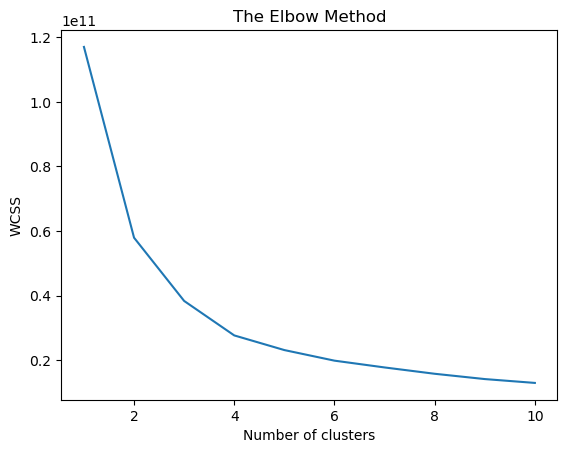

In [12]:
# get number of optimal clusters by using elbowplot method
number_of_clusters=elbow_plot(X)

# build clusters

In [13]:
# function to Divide the data into clusters
def create_clusters(data,number_of_clusters):
    kmeans = KMeans(n_clusters=number_of_clusters, init='k-means++', random_state=42)
    y_kmeans=kmeans.fit_predict(data) #  divide data into clusters
    data['Cluster']=y_kmeans  # create a new column in dataset for storing the cluster information
    return data

In [14]:
# Divide the data into clusters
X=create_clusters(X,3)

In [15]:
# cluster with value counts in each cluster
X.Cluster.value_counts()

1    6690
0    2069
2     228
Name: Cluster, dtype: int64

In [16]:
list_of_clusters=X['Cluster'].unique()
list_of_clusters

array([1, 0, 2], dtype=int32)

# Train SVR and RF on each cluster, save best model out of them for each cluster

Hyperparameters for RF

In [17]:
def get_best_params_for_Random_Forest_Regressor(train_x, train_y):
    RandomForestReg = RandomForestRegressor()
    param_grid_Random_forest_Tree = {
                "n_estimators":  [100],                            #[10, 20, 30], 
                "max_features": ["auto"],                            #[, "sqrt", "log2"],
                "min_samples_split": [2],                            #, 4, 8],
                "bootstrap": [True],                            #[, False]
            }
    grid = GridSearchCV(RandomForestReg, param_grid_Random_forest_Tree, verbose=3, cv=5)
    grid.fit(train_x, train_y)
    # extracting the best parameters
    n_estimators = grid.best_params_['n_estimators']
    max_features = grid.best_params_['max_features']
    min_samples_split = grid.best_params_['min_samples_split']
    bootstrap = grid.best_params_['bootstrap']
    decisionTreeReg = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features,
                                                         min_samples_split=min_samples_split,
                                                         bootstrap=bootstrap)
    decisionTreeReg.fit(train_x, train_y)
    return decisionTreeReg


Hyperparameters for SVR

In [18]:
def get_best_params_for_SVR( train_x, train_y):
    svr_reg= SVR()
    param_SVR = {'kernel': ['rbf'],                            #, 'linear', 'poly', 'sigmoid'],
                              'gamma': ['scale'],                            #, 'auto'],
                              'C': [1.0],                            #0.001, 0.01, 0.1, 1, 10, 20, 50, 100]
                              }
    grid = GridSearchCV(svr_reg, param_SVR, verbose=3, cv=5)
    grid.fit(train_x, train_y)
    # extracting the best parameters
    kernel = grid.best_params_['kernel']
    gamma = grid.best_params_['gamma']
    C = grid.best_params_['C']
    SVreg = SVR(kernel=kernel, gamma=gamma,
                           C=C)
    SVreg.fit(train_x, train_y)
    return SVreg

Compaire and get best model

In [19]:
def get_best_model(train_x, train_y, test_x, test_y):
    # create best model for RF
    randomForestReg = get_best_params_for_Random_Forest_Regressor(train_x, train_y)
    prediction_randomForestReg = randomForestReg.predict(test_x)  # Predictions using the randomForestReg Model
    prediction_randomForestReg_error = r2_score(test_y, prediction_randomForestReg)

    # create best model for SVR
    SVR = get_best_params_for_SVR(train_x, train_y)
    prediction_SVR = SVR.predict(test_x)  # Predictions using the LinearReg Model
    SVR_error = r2_score(test_y, prediction_SVR)

    # save scores df
    scores = [SVR_error, prediction_randomForestReg_error]
    scores = sorted(scores, reverse=True)

    # Import writer class from csv module
    from csv import writer
    with open('results/cluster_scores.csv', 'a') as f_object:
        writer_object = writer(f_object)
        writer_object.writerow(scores)
        f_object.close()

    # comparing the two models, return best

    if (SVR_error < prediction_randomForestReg_error):
        return 'RandomForestRegressor', randomForestReg
    else:
        return 'SVR', SVR

Save best model into models directory according to best performing model on each cluster

In [20]:
def save_model(model,filename):
    path = os.path.join('models/',filename)
    if os.path.isdir(path): #remove previously existing models for each clusters
        shutil.rmtree('models/')
        os.makedirs(path)
    else:
        os.makedirs(path) #
        with open(path +'/' + filename+'.sav','wb') as f:
            pickle.dump(model, f)

In [21]:
X['Labels'] = Y

In [22]:
for i in list_of_clusters:
    # filter the data for one cluster
    cluster_data=X[X['Cluster']==i] 
    cluster_features=cluster_data.drop(['Labels','Cluster'],axis=1)
    cluster_label= cluster_data['Labels']
    
    # splitting the data into training and test set for each cluster one by one
    x_train, x_test, y_train, y_test = train_test_split(cluster_features, cluster_label, test_size=1 / 3, random_state=36)
    scalar = StandardScaler()
    x_train_scaled = scalar.fit_transform(x_train)
    x_test_scaled = scalar.fit_transform(x_test)
    # train-model
    best_model_name, rf = get_best_model(x_train, y_train, x_test, y_test)
    save =save_model(rf,best_model_name+str(i))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100;, score=0.784 total time=   6.7s
[CV 2/5] END bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100;, score=0.785 total time=   6.7s
[CV 3/5] END bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100;, score=0.736 total time=   6.8s
[CV 4/5] END bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100;, score=0.812 total time=   6.8s
[CV 5/5] END bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100;, score=0.756 total time=   6.7s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.429 total time=   1.0s
[CV 2/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.461 total time=   1.0s
[CV 3/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.463 total time=   1.0s
[CV 4/5] END ....C=1.0, gamma=scale, kernel=

# Barplot of model performances on  each cluster

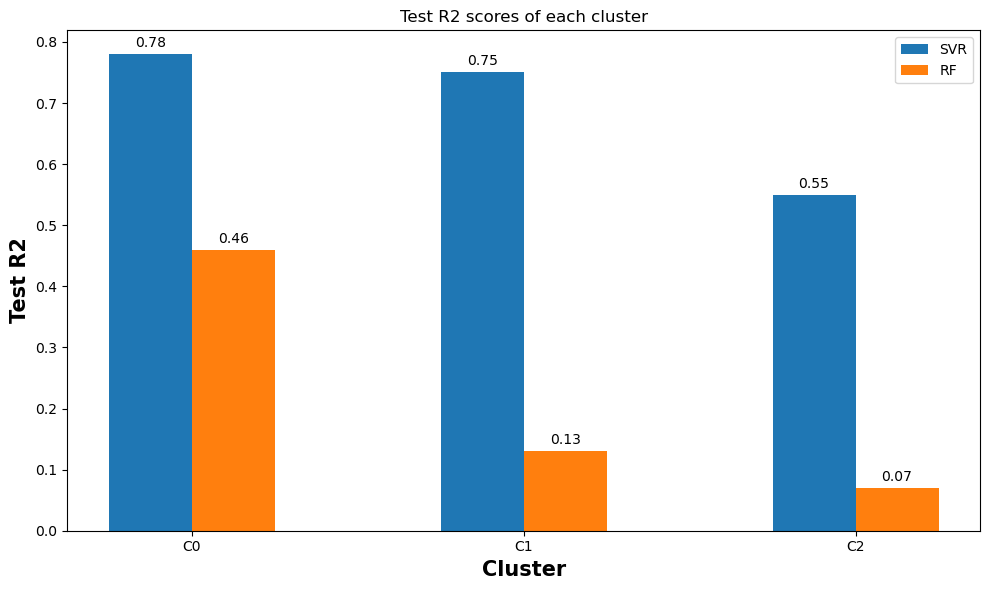

In [23]:
## save barplot
df = pd.read_csv("results/cluster_scores.csv")

labels = ['C0', 'C1', 'C2']
SVR = np.round_(df["SVR"].tolist(), decimals=2)
RF = np.round_(df["RF"].tolist(), decimals=2)

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width / 2, SVR, width, label='SVR')
rects2 = ax.bar(x + width / 2, RF, width, label='RF')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Test R2', fontweight='bold', fontsize=15)
ax.set_xlabel('Cluster', fontweight='bold', fontsize=15)
ax.set_title('Test R2 scores of each cluster')
ax.set_xticks(x, labels)
ax.legend()
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
fig.tight_layout()
plt.savefig("results/cluster_scores.png")

# Visualisation of clusters

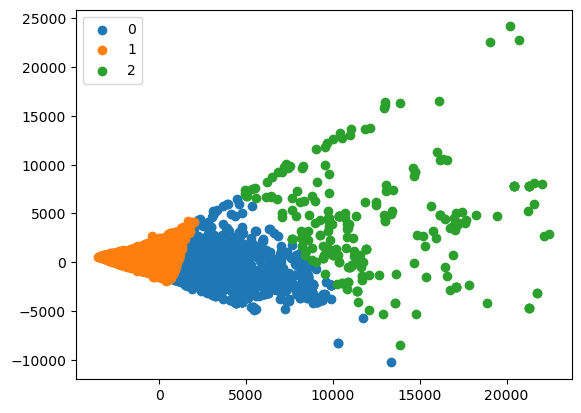

In [24]:
#Load Data
data = X
pca = PCA(2)

#Transform the data
df = pca.fit_transform(data)
#Import KMeans module
from sklearn.cluster import KMeans
 
#Initialize the class object
kmeans = KMeans(n_clusters= 3)
 
#predict the labels of clusters.
label = kmeans.fit_predict(df)
 
#Getting unique labels
u_labels = np.unique(label)
 
#plotting the results:
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.show()